## Decision Trees and Random Forests

[Decision Trees](http://scikit-learn.org/stable/modules/tree.html) are a model for classification that utilizes trees.  Each node in the decision tree applies an inequality to a particular feature, resulting in a boolean output.  For each of the two possible outputs, there is a child node.  The leaves of the tree representing classification decisions; the predicted labels for the leaf nodes come from determining what the most common label is among the samples at that leaf. 

The decision tree is trained through a greedy algorithm.  All combinations of features and thresholds are evaluated at each split.  The feature and threshold combination that optimizes the "gini impurity" is used for that node.  The goal is to divide the divide by class as quickly as possible.

To classify a given sample, you start from the top of the tree.  At each node, you evaluate the inequality and move the sample down to the left (true) or right (false) child.  When you reach a leaf, you use the label associated with that leaf to classify the sample.

Advantages of decision trees include:

* Feature selection -- the decision tree can pick the fits it finds to be most useful
* Interpretability -- decision trees can be easily interpreted to explain how samples are classified

The downsides of decision trees include:

* Unstable -- small changes in the training set can result in very different trees
* Feature selection is good but not perfect
* Not as accurate as other technique

To illustrate the feature selection capabilities, we'll use our greedy method for choosing features and compare with training a decision tree on all of our features.  We'll then repeat this process using [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), a more advanced technique that builds on decision trees.

For this tutorial, we will use the Wisconsin breast cancer data set.  We will classify tumors as benign or malignant based on their properties.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.utils import resample

iris = load_iris()


%matplotlib inline

## Import and Clean Data

In [4]:
df = pd.read_csv("breast_cancer.csv")

In [5]:
df.head()

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,benign
1,1002945,5,4,4,5,7,10.0,3,2,1,benign
2,1015425,3,1,1,1,2,2.0,3,1,1,benign
3,1016277,6,8,8,1,3,4.0,3,7,1,benign
4,1017023,4,1,1,3,2,1.0,3,1,1,benign


In [6]:
df.dtypes

Id                   int64
Cl.thickness         int64
Cell.size            int64
Cell.shape           int64
Marg.adhesion        int64
Epith.c.size         int64
Bare.nuclei        float64
Bl.cromatin          int64
Normal.nucleoli      int64
Mitoses              int64
Class               object
dtype: object

## Data Exploration

Let's look at the distribution of the outcome variable `Class`.

benign       458
malignant    241
Name: Class, dtype: int64


Text(0,0.5,'Number of Samples')

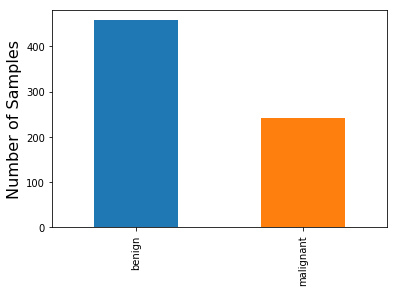

In [7]:
class_counts = df["Class"].value_counts()
print(class_counts)
class_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Our data set is imbalanced.  Meaning, we have twice as many benign samples as malignant samples.

## Experimental Setup

In [8]:
df_train, df_test = train_test_split(df, stratify=df["Class"])
print(df.shape[0], df_train.shape[0], df_test.shape[0])

699 524 175


Our labels are given as a strings, which we then converted to a categorical variable.  Scikit-Learn classifiers expect that outcome variables are denoted by integers -- one integer per category.  We can use the `LabelEncoder` to transform the strings to integers and store an internal representation for easier conversation back later.

In [9]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["Class"].astype("str"))
y_test = encoder.transform(df_test["Class"].astype("str"))
print(y_train)

[0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1
 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0
 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0
 0 1 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0
 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 

## Feature Selection with Greedy Algorithm

The Wisconsin Breast Cancer data set features are all numerical, so we don't transform anything into dummy variables.  We just create some placeholder data structures so we can reuse our existing code.

In [10]:
candidate_columns = df.columns[1:-1]
dummy_columns = dict()

In [11]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        imputer = Imputer()
        X_train_numerical = imputer.fit_transform(X_train_numerical)
        X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

Now, let's try putting all of our features into a Decision Tree model.

In [12]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          candidate_columns,
                                          dummy_columns)
    
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred_labels = dt.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_labels)
cm = confusion_matrix(y_test, pred_labels)
print()
print("Model Accuracy:", trial_accuracy)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)


Model Accuracy: 0.9314285714285714
Labels: ['benign' 'malignant']
Confusion matrix:
[[109   6]
 [  6  54]]


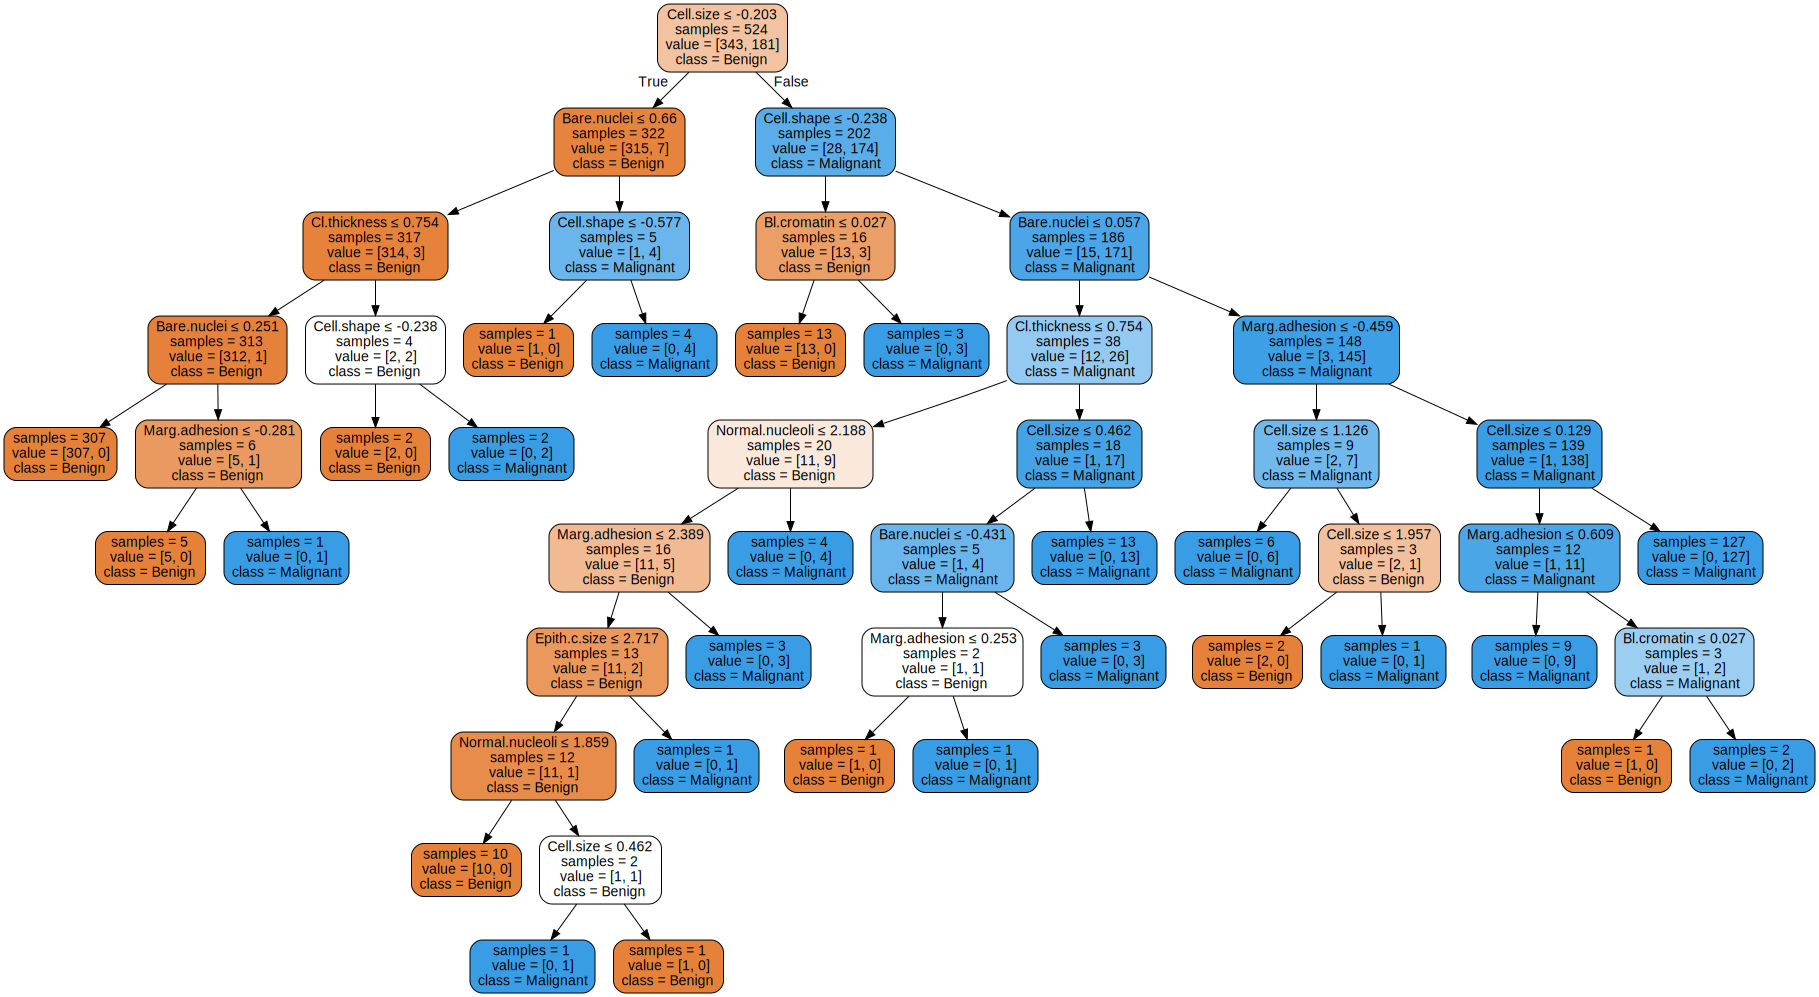

In [16]:
dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=candidate_columns,  
                         class_names=["Benign", "Malignant"],  
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graphviz.Source(dot_data)

## Iris

In [26]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data, iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_original_1',view=True)

'iris_original_1.png'

In [27]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data, iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_original_2',view=True)

'iris_original_2.png'

In [28]:


resampled_X, resampled_y = resample(iris.data, iris.target)
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(resampled_X, resampled_y)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_resample_1',view=True)

'iris_resample_1.png'

In [29]:
resampled_X, resampled_y = resample(iris.data, iris.target)
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(resampled_X, resampled_y)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_resample_2',view=True)

'iris_resample_2.png'

In [17]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data[:,:2], iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_first_two',view=True)

'iris_first_two.png'

In [20]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data[:,1:3], iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names[1:3],  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_1_2',view=True)

'iris_1_2.png'

In [21]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data[:,2:], iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=iris.feature_names[2:],  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_2_3',view=True)

'iris_2_3.png'

In [24]:
dt = DecisionTreeClassifier(min_samples_leaf=2)
dt.fit(iris.data[:,[0, 3]], iris.target)

dot_data = export_graphviz(dt, out_file=None, 
                         feature_names=np.array(iris.feature_names)[[0, 3]],  
                         class_names=iris.target_names, 
                         filled=True, rounded=True, impurity=False, 
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('iris_0_3',view=True)

'iris_0_3.png'

In [27]:
print(resample([1, 2, 3, 4, 5]))
print(resample([1, 2, 3, 4, 5]))
print(resample([1, 2, 3, 4, 5]))
print(resample([1, 2, 3, 4, 5]))

[4, 3, 1, 1, 4]
[5, 3, 5, 5, 4]
[1, 1, 2, 2, 2]
[3, 5, 3, 4, 2]
